In [1]:
import os
from matplotlib import pyplot
import numpy as np
import numpy.testing as npt
from scipy.spatial.transform import Rotation
import pickle
from PIL import Image
from IPython.display import display
from ipywidgets import interact
from importlib import reload
import functools
import tqdm

In [2]:
import trimesh
import pyrender

In [3]:
from face3drotationaugmentation.facemodel.bfm import BFMModel
import face3drotationaugmentation.dataset300wlp as dataset300wlp
import face3drotationaugmentation.vis as vis

In [4]:
reload(vis)

<module 'face3drotationaugmentation.vis' from '/mnt/SSDNTFS/Programmierung/head-tracking/face-3d-rotation-augmentation/face3drotationaugmentation/vis.py'>

In [5]:
ds300wlp = dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'))

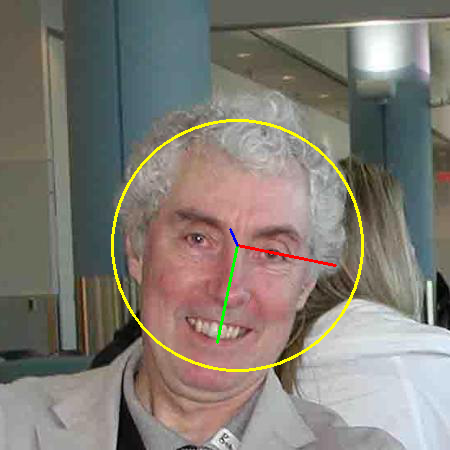

In [6]:
original_sample = ds300wlp[21]
img = original_sample['image'].copy()
vis.draw_pose(img, original_sample, 255, 2)
display(Image.fromarray(img))

In [7]:
#os.environ['PYOPENGL_PLATFORM'a] = 'egl'

In [8]:
def get_hpb(rot : Rotation):
    '''Conversion to heading-pitch-bank.
    
    First rotation is around z (bank/roll), then x (pitch), then y (yaw/heading)
    '''
    return rot.as_euler('YXZ')


def make_rot_by_axis_rotations(hpb):
    '''For testing - to ensure we have the right convention.'''
    h, p, b = hpb.T
    z = np.zeros(h.shape)
    return Rotation.from_rotvec(np.vstack([z,h,z]).T) * Rotation.from_rotvec(np.vstack([p,z,z]).T) * Rotation.from_rotvec(np.vstack([z,z,b]).T)


def make_rot(hpb):
    '''Conversion from heading-pitch-bank.
    
    First rotation is around z (bank/roll), then x (pitch), then y (yaw/heading)
    '''
    return Rotation.from_euler('YXZ', hpb)


def affine3d_chain(Ta, Tb):
    Ra, ta = Ta
    Rb, tb = Tb
    return Ra*Rb, Ra.apply(tb) + ta


def affine3d_inv(Ta):
    Ra, ta = Ta
    RaInv = Ra.inv()
    return RaInv, -RaInv.apply(ta)


def test_euler_angle_functions():
    ref_rots = Rotation.random(num=1000)
    hpb = get_hpb(ref_rots)
    rots = make_rot(hpb)
    npt.assert_array_less((rots.inv() * ref_rots).magnitude(), 1.e-6)
    npt.assert_array_less((rots.inv() * make_rot_by_axis_rotations(hpb)).magnitude(), 1.e-6)

    
test_euler_angle_functions()

In [9]:
def load_base_mesh(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        tris = np.asarray(data['tris'])
        base_vertices = np.asarray(data['vertices'])
        base_vertices *= 0.01  # Vertices were changed during import in 3d software
        base_vertices[:,1] *= -1 # Vertices were changed during import in 3d software
        blend_weights = np.asarray(data['weights'])
        # Dummy is good enough for unlit scene
        normals = np.broadcast_to(np.asarray([[ 0., 0., 1.]]), (len(base_vertices),3))
        return base_vertices, tris, blend_weights, normals

In [10]:
%matplotlib inline

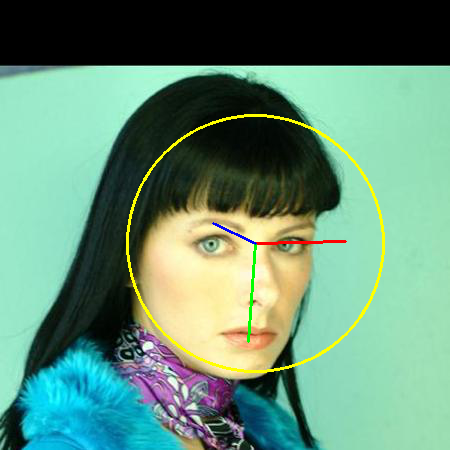

In [11]:
sample = ds300wlp[19]
img = sample['image'].copy()
vis.draw_pose(img, sample, 255, 2)
display(Image.fromarray(img))

In [12]:
def apply_s_rot_t(vertices, xy, scale, rot):
    vertices = rot.apply(vertices * scale)
    vertices[...,:2] += xy
    return vertices


def apply_blendshapes(vertices, blend_shape_vertices, shapeparam):
    return vertices + np.sum((blend_shape_vertices * shapeparam[:,None,None]), axis=0)



class FaceWithBackgroundModel(object):
    def __init__(self, base_mesh, bfm, xy, scale, rot, shapeparam, image):
        self._base_vertices, self._tris, self._blend_weights, self._normals = base_mesh
        self._bfm = bfm
        self._rot = rot
        self._xy = xy
        self._scale = scale
        # Center for the augmented rotation. It is specified in the local BFM frame.
        self._rotation_center = np.array([0., 0.33, 0.25])

        h, w = image.shape[:2]

        # Extra border to generate black pixels outside of the original image region.
        # Because the the deformation will pull parts of the mesh into the view which
        # were not part of the original image.
        texture_border = 50 # pixels
        
        vertices_for_uv, _ = self._compute_face_vertices_with_background(Rotation.identity(), shapeparam)
        # By default, without texture border, the range from [0,w] is mapped to [0,1]
        # With border ...
        #    Range from -border to w+border is mapped to [0,1]
        uvs = (vertices_for_uv[:,:2] + texture_border) / (np.asarray([[w, h]]) + 2*texture_border)
        uvs[:,1] = 1. - uvs[:,1]
        self._uvs = uvs

        self.background_plane_z_coord = np.average(vertices_for_uv[self._blend_weights < 0.01,2])

        # Dummy data is good enough for unlit scene
        self._normals = np.broadcast_to(np.asarray([[ 0., 0., 1.]]), (len(self._base_vertices),3))

        tex = np.zeros((h+2*texture_border,w+2*texture_border,4), dtype=np.uint8)
        tex[texture_border:-texture_border, texture_border:-texture_border,:3] = image
        tex[:,:,3] = 255 # Alpha channel

        self._tex = pyrender.Texture(
            source = tex,
            source_channels = 'RGBA', # RGB doesn't work
            data_format = pyrender.texture.GL_UNSIGNED_BYTE,
            sampler = pyrender.Sampler(
                wrapS=pyrender.GLTF.CLAMP_TO_EDGE, 
                wrapT=pyrender.GLTF.CLAMP_TO_EDGE)
        )
    
        self._mat = pyrender.MetallicRoughnessMaterial(baseColorTexture=self._tex, doubleSided=False)


    def _compute_combined_transform(self, rotoffset):
        # The new rotation shall take place about self._rotation_center
        # 1. Transform center to world space: (center' = Tr @ center)
        # 2. transform verts according to sample parameters: (v = (Tr @ shaping_result)
        # 3. rotate verts by augmented rotation offset around center v' = (Tr2 @ (v-center)) + center
        # 4. blend: v*f + (1-f)*shaping_result
        # However, the rigid transformations can be rewritten as
        # v' = (Tr2 @ ((Tr @ s) - center) + center
        #    = Tr2' @ Tr' @ s
        # With Tr2' like Tr2 with translation + center
        # and  Tr' like Tr with translation - center
        # Then Tr2 and Tr can be combined together
        center = apply_s_rot_t(self._rotation_center, self._xy, self._scale, self._rot)
        T1_t = np.asarray([self._xy[0], self._xy[1], 0.]) - center
        T1_rot = self._rot
        T2_t = center
        T2_rot = rotoffset
        R, t = affine3d_chain((T2_rot,T2_t),(T1_rot,T1_t))
        return self._scale, R, t


    def _compute_face_vertices_with_background(self, rotoffset, shapeparam):
        vertices = self._base_vertices.copy()
        vertices[:self._bfm.vertexcount] = apply_blendshapes(self._base_vertices[:self._bfm.vertexcount], self._bfm.scaled_bases, shapeparam)
        s, R, t = self._compute_combined_transform(rotoffset)
        vertices1 = apply_s_rot_t(vertices, self._xy, self._scale, Rotation.identity())
        vertices2 = apply_s_rot_t(vertices, t[:2], s, R)
        f = self._blend_weights
        final_vertices = vertices2*f[:,None] + (1.-f)[:,None]*vertices1
        return final_vertices, (R, t)  #apply_s_rot_t(np.zeros((3,)), t[:2]], s, R))


    def __call__(self, rotoffset, shapeparam):
        vertices, tr = self._compute_face_vertices_with_background(rotoffset, shapeparam)
        prim = pyrender.Primitive(positions = vertices, indices=self._tris, texcoord_0 = self._uvs, normals=self._normals, material=self._mat)
        return pyrender.Mesh(primitives = [prim]), tr

In [13]:
def add_camera(scene, image_shape, scale, background_plane_z_coord):
    h, w, _ = image_shape
    zdistance = 10000
    fov = 2.*np.arctan(0.5*(h)/(zdistance + background_plane_z_coord))
    cam = pyrender.PerspectiveCamera(yfov=fov, znear = zdistance-scale*2, zfar = zdistance+scale*2)
    campose = np.eye(4)
    campose[:3,3] = [ w//2, h//2, -zdistance  ]
    campose[:3,:3] = [
        [ 1, 0, 0 ],
        [ 0, 0, -1 ],
        [ 0, -1, 0 ]
    ]
    scene.add(cam, pose=campose)

In [14]:
def launch_pyrender_viewer(sample):
    xy = sample['xy']
    scale = sample['scale']
    shapeparam = sample['shapeparam']
    image = sample['image']
    rot = sample['rot']
    h, w, _ = image.shape
    base_mesh = load_base_mesh("face3drotationaugmentation/full_bfm_mesh_with_bg.pkl")
    bfm = BFMModel(40, 10)
    face_model = FaceWithBackgroundModel(base_mesh, bfm, xy, scale, rot, shapeparam, image)
    scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[0.0, 0.0, 0.0])
    add_camera(scene, image.shape, scale, face_model.background_plane_z_coord)
    mesh, _ = face_model(Rotation.identity(), shapeparam)
    scene.add(mesh)
    pyrender.Viewer(scene, viewport_size=(w,h))

launch_pyrender_viewer(sample)

In [15]:
class FaceAugmentationRenderer(object):
    def __init__(self, sample):
        xy = sample['xy']
        scale = sample['scale']
        shapeparam = sample['shapeparam']
        image = sample['image']
        rot = sample['rot']
        h, w, _ = image.shape
        base_mesh, bfm = FaceAugmentationRenderer._load_assets()
        self.renderer = pyrender.OffscreenRenderer(viewport_width=w, viewport_height=h)
        self.face_model = face_model = FaceWithBackgroundModel(base_mesh, bfm, xy, scale, rot, shapeparam, image)
        self.scene = scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[0.0, 0.0, 0.0])
        add_camera(scene, image.shape, scale, face_model.background_plane_z_coord)

    def __call__(self, rotoffset, shapeparam):
        mesh, tr = self.face_model(rotoffset, shapeparam)
        face_node = self.scene.add(mesh)
        color, _ = self.renderer.render(self.scene)
        color = np.ascontiguousarray(color)
        self.scene.remove_node(face_node)
        return color, tr

    @staticmethod
    @functools.cache
    def _load_assets():
        base_mesh = load_base_mesh("face3drotationaugmentation/full_bfm_mesh_with_bg.pkl")
        bfm = BFMModel(40, 10)
        return base_mesh, bfm


In [16]:
facerenderer = FaceAugmentationRenderer(sample)

@interact(yaw = (-1.5, 1.5), pitch = (-1., 1.))
def showit(yaw, pitch):
    rotoffset = Rotation.from_rotvec([0., yaw, 0.]) * Rotation.from_rotvec([ pitch, 0., 0.])

    color, (R,t) = facerenderer(rotoffset, sample['shapeparam'])

    vis.draw_pose(color, {
        'rot' : R,
        'xy' : t,
        'scale' : sample['scale']
    }, 255, 2)

    display(Image.fromarray(color))

interactive(children=(FloatSlider(value=0.0, description='yaw', max=1.5, min=-1.5), FloatSlider(value=0.0, des…

In [17]:
deg2rad = np.pi/180.

def get_euler_angle_bounds_for_offset(rot):
    h,p,b = map(lambda x: x/deg2rad, get_hpb(rot))
    h_min = min(np.abs(h), -90. + 3*2*min(np.abs(h),90.), 90.)
    h_max = 90.
    if h < 0.:
        h_min, h_max = -h_max, -h_min
    # for zero yaw
    p_min = -45. + 2.*min(np.abs(p), 45.)
    p_max =  45.
    if p < 0.:
        p_min, p_max = -p_max, -p_min
    # for the current yaw, we can be more liberal because the more the face is 
    # viewed from the side, the more pitch becomes an in-plane rotation which 
    # imposes no visibility restrictions:
    mix = min(np.abs(h),90.)/90.
    p_min = -45*mix + (1.-mix)*p_min
    p_max =  45*mix + (1.-mix)*p_max
    # Roll is similar to pitch except the yaw-role is reversed
    b_min = -20 + 2.*min(np.abs(b), 20.)
    b_max =  20
    if b < 0.:
        b_min, b_max = -b_max, -b_min
    mix = min(np.abs(h),90.)/90.
    b_min = -20.*(1.-mix) + mix*b_min
    b_max =  20.*(1.-mix) + mix*b_max
    return (h_min*deg2rad, h_max*deg2rad), (p_min*deg2rad, p_max*deg2rad), (b_min*deg2rad, b_max*deg2rad)

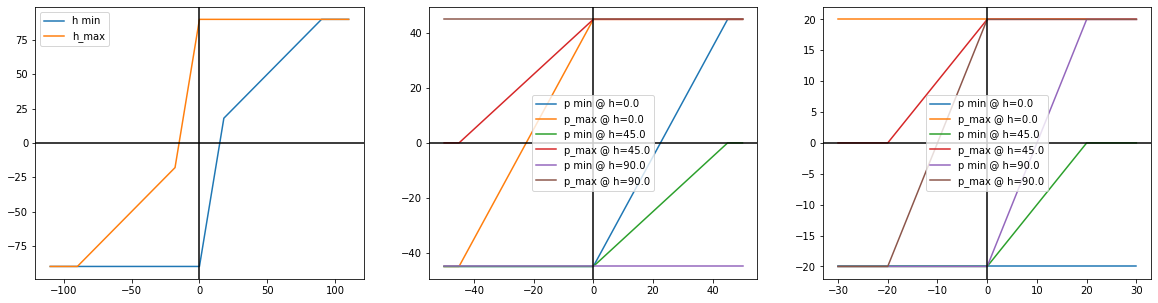

In [18]:
def plot_euler_angle_bounds():
    fig, axes = pyplot.subplots(1,3, figsize=(20,5))
    hs = np.linspace(-110.,110.,221)
    p = 0.
    b = 0.
    h_ranges = np.asarray([ get_euler_angle_bounds_for_offset(make_rot([h,p,b]))[0] for h in (deg2rad*hs) ]) / deg2rad
    ax = axes[0]
    ax.plot(hs, h_ranges.T[0], label='h min')
    ax.plot(hs, h_ranges.T[1], label='h_max')
    ax.axhline(c = 'k')
    ax.axvline(c = 'k')
    ax.legend()

    ax = axes[1]
    for h in deg2rad*np.asarray([0., 45, 90.]):
        ps = np.linspace(-50.,50.,101)
        b = 0.
        p_ranges = np.asarray([ get_euler_angle_bounds_for_offset(make_rot([h,p,b]))[1] for p in (deg2rad*ps) ]) / deg2rad
        ax.plot(ps, p_ranges.T[0], label=f'p min @ h={h/deg2rad:0.1f}')
        ax.plot(ps, p_ranges.T[1], label=f'p_max @ h={h/deg2rad:0.1f}')
    ax.axhline(c = 'k')
    ax.axvline(c = 'k')
    ax.legend()

    ax = axes[2]
    for h in deg2rad*np.asarray([0., 45, 90.]):
        bs = np.linspace(-30.,30.,61)
        p = 0.
        b_ranges = np.asarray([ get_euler_angle_bounds_for_offset(make_rot([h,p,b]))[2] for b in (deg2rad*bs) ]) / deg2rad
        ax.plot(bs, b_ranges.T[0], label=f'p min @ h={h/deg2rad:0.1f}')
        ax.plot(bs, b_ranges.T[1], label=f'p_max @ h={h/deg2rad:0.1f}')
    ax.axhline(c = 'k')
    ax.axvline(c = 'k')
    ax.legend()

    pyplot.show()

plot_euler_angle_bounds()

In [19]:
def compute_heading_sample(h, hinterval, n):
    hmin, hmax = hinterval
    hmin, hmax = hmin/deg2rad, hmax/deg2rad
    h = np.clip(h/deg2rad,-90.,90.)
    width = hmax-hmin
    gaussian_probability = np.clip((width-90.)/90., 0., 1.)
    samples = np.random.exponential(scale=0.25, size=(n,))*width*np.sign(h) + h
    mask = np.random.binomial(1, p=gaussian_probability, size=(n,)).astype(np.bool8)
    samples[mask] = np.random.normal(scale=20.,size=(np.count_nonzero(mask),))
    samples = np.clip(samples, -100., 100.)
    samples *= deg2rad
    return samples


def sample_more_face_params(rot, n):
    h,p,b = get_hpb(rot)
    hinterval, pinterval, rinterval = get_euler_angle_bounds_for_offset(rot)
    low, high = zip(hinterval, pinterval, rinterval)
    low, high = map(np.asarray, (low, high))
    #hpb = np.random.uniform(low = low, high=high, size=(n,3))
    hpb = np.clip(np.random.normal(size=(n,3))*(high-low)[None,:]*0.25 + 0.5*(high+low)[None,:], low[None,:], high[None,:])
    #hpb[:,0] = compute_heading_sample(h, hinterval, n)
    return make_rot(hpb)

In [20]:
sample = ds300wlp[20]
shapetransfer_sample = ds300wlp[21]

more_rots = sample_more_face_params(sample['rot'],20)

facerenderer = FaceAugmentationRenderer(sample)

@interact(i = (0, len(more_rots)-1))
def showit(i):
    rotoffset = sample['rot'].inv()*more_rots[i]

    color, (R,t) = facerenderer(rotoffset, shapetransfer_sample['shapeparam'])

    vis.draw_pose(color, {
        'rot' : R,
        'xy' : t,
        'scale' : sample['scale']
    }, 255, 2)

    print (f"hpb = {get_hpb(more_rots[i])/deg2rad}")
    display(Image.fromarray(np.hstack([sample['image'],color])))

interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…

In [21]:
all_rots = [ s['rot'] for s in tqdm.tqdm(ds300wlp) ]
# Join rotations into a single array
all_rots = Rotation.from_quat(np.asarray([ r.as_quat() for r in all_rots ]))

100%|██████████| 3837/3837 [00:22<00:00, 171.28it/s]


In [22]:
print (f"Number of frames: {len(all_rots)}")

Number of frames: 3837


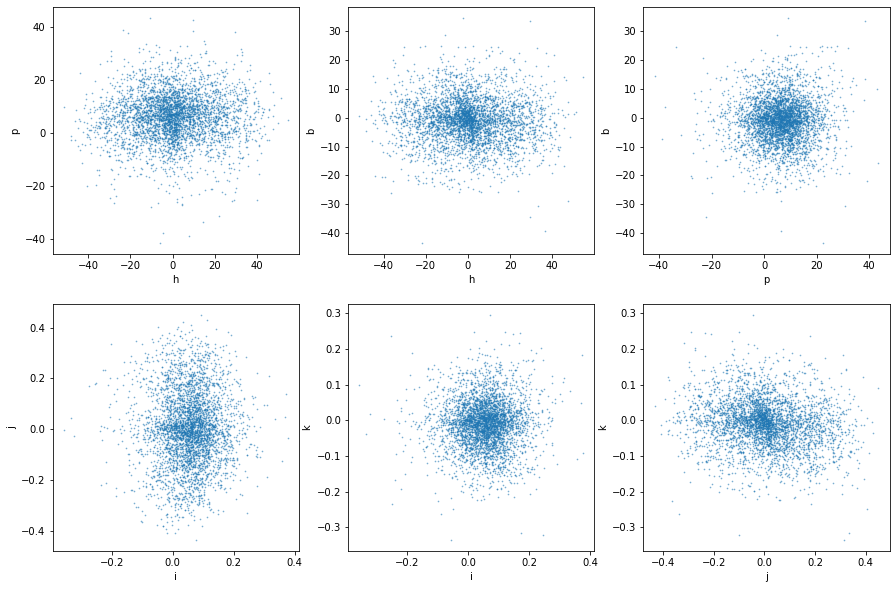

In [23]:
def plot_rotation_distribution(all_rots):
    hpb = get_hpb(all_rots)
    quats = all_rots.as_quat()
    fig, axes = pyplot.subplots(2,3, figsize=(15,10))
    axes = axes.ravel()
    ax = axes[0]
    names = 'h p b'.split()
    pairs = [ (0,1), (0,2), (1,2) ]
    for ax, (i,j) in zip(axes[:3],pairs):
        ax.scatter(hpb.T[i]/deg2rad, hpb.T[j]/deg2rad, s=0.5, alpha=0.5)
        ax.set(xlabel=names[i], ylabel=names[j])
    names = 'i j k'.split()
    for ax, (i,j) in zip(axes[3:],pairs):
        ax.scatter(quats.T[i], quats.T[j], s=0.5, alpha=0.5)
        ax.set(xlabel=names[i], ylabel=names[j])

plot_rotation_distribution(all_rots)

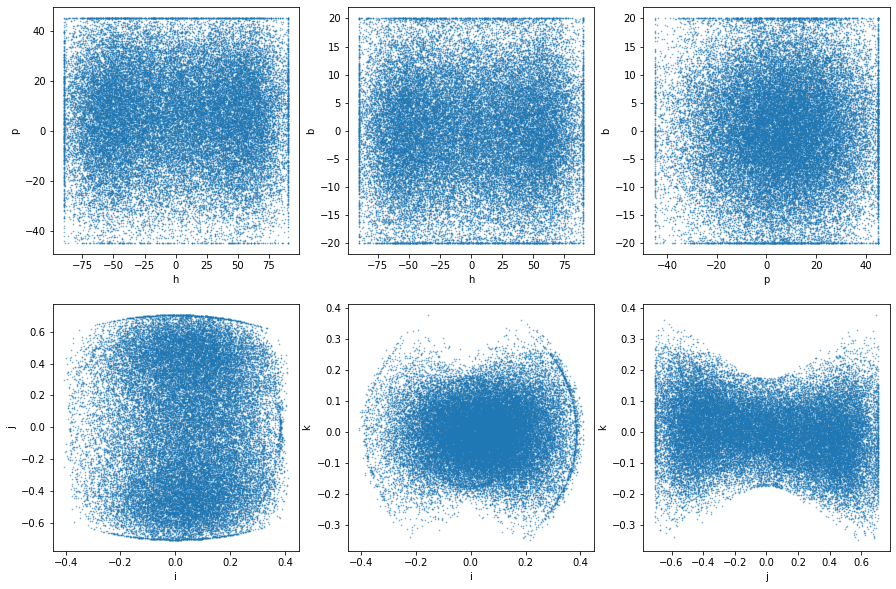

In [24]:
synthetic_rots = Rotation.from_quat(np.concatenate([ sample_more_face_params(rot,10).as_quat() for rot in all_rots ], axis=0))
plot_rotation_distribution(synthetic_rots)

100%|██████████| 61225/61225 [02:48<00:00, 363.73it/s]


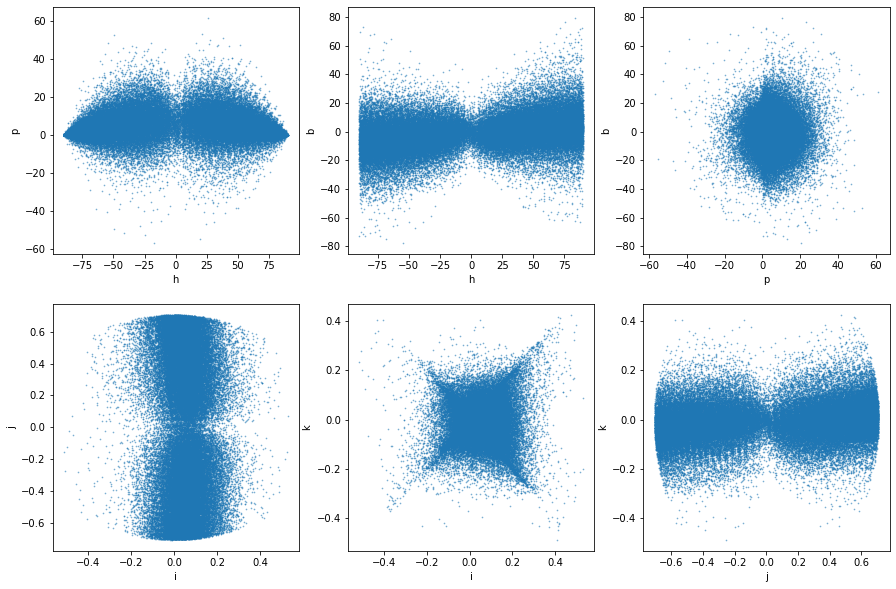

In [25]:
ds300wlp.close()
ds300wlp = dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'), only_originals=False)

all_rots = [ s['rot'] for s in tqdm.tqdm(ds300wlp) ]
# Join rotations into a single array
all_rots = Rotation.from_quat(np.asarray([ r.as_quat() for r in all_rots ]))

plot_rotation_distribution(all_rots)

ds300wlp.close()